In [55]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm.notebook import tqdm
import os

# Проблема подглядывания


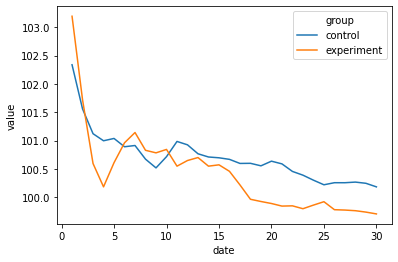

In [35]:
days = 30
mu_control, sigma_control, n_control = 100, 20, 100
mu_experiment, sigma_experiment, n_experiment = 100, 20, 100

def experiment(current_date=1):
    user_data = pd.DataFrame()
    stat_result = pd.DataFrame()
    daily_data = pd.DataFrame()

    for day in range(days):
        daily_data_control = np.random.normal(mu_control, sigma_control, n_control)
        daily_data_experiment = np.random.normal(mu_experiment, sigma_experiment, n_experiment)

        day_data_control = pd.DataFrame({'value': daily_data_control})
        day_data_control['date'] = current_date
        day_data_control['group'] = 'control'


        day_data_experiment = pd.DataFrame({'value': daily_data_experiment})
        day_data_experiment['date'] = current_date
        day_data_experiment['group'] = 'experiment'


        user_data = user_data.append(day_data_experiment).append(day_data_control)
        fit = stats.ttest_ind(user_data[user_data.group == 'experiment'].value,
                              user_data[user_data.group == 'control'].value)


        stat_result = stat_result.append(pd.DataFrame({'t': [fit[0]], 'p': [fit[1]], 'date': current_date}))


        current_data_stat = user_data.groupby(['group'], as_index=False).agg({'value': 'mean'})
        current_data_stat['date'] = current_date

        daily_data = daily_data.append(current_data_stat)

        current_date += 1
    return user_data, stat_result, daily_data


user_data, stat_result, daily_data = experiment()
ax = sns.lineplot(data=daily_data, x="date", y="value", hue='group')
plt.savefig("two_groups.pdf")

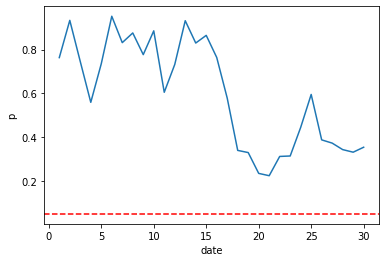

In [36]:
ax = sns.lineplot(data=stat_result, x="date", y="p")
ax.axhline(0.05, ls='--', color='red')
plt.savefig("p-values.pdf")

In [102]:
n_experiments = 50
correct_strategy_p, false_strategy_p = [], []
for _ in tqdm(range(n_experiments)):
    user_data, stat_result, daily_data = experiment()
    correct_strategy_p.append(stat_result.query("date == 14")['p'].values[0])
    for numer, p_values in enumerate(stat_result['p'][:15]):
        if (p_values <= 0.05) | (numer == 14):
            false_strategy_p.append(p_values)
            break

print(f"Доля неверных выводов БЕЗ ОШИБКИ ПОДГЛЯДЫВАНИЯ: "
      f"{np.round(np.sum(np.array(correct_strategy_p) <= 0.05) / n_experiments, 3)}")
print(f"Доля неверных выводов C ОШИБКОЙ ПОДГЛЯДЫВАНИЯ: "
      f"{np.round(np.sum(np.array(false_strategy_p) <= 0.05) / n_experiments, 3)}")


  0%|          | 0/50 [00:00<?, ?it/s]

Доля неверных выводов БЕЗ ОШИБКИ ПОДГЛЯДЫВАНИЯ: 0.02
Доля неверных выводов C ОШИБКОЙ ПОДГЛЯДЫВАНИЯ: 0.18


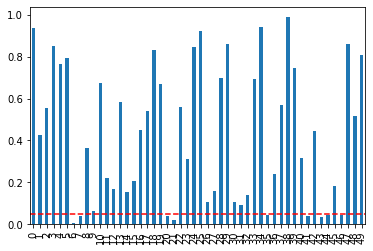

In [104]:
ax = pd.Series(false_strategy_p).plot(kind='bar')
ax.axhline(0.05, ls='--', color='red')
plt.savefig("p-values.pdf")

In [95]:
os.getcwd()

'/Users/iakubovskii/AppBooster/AB_testing/Data/Quantum_AB_historic/ARPU/IOS/Revenue'

# Множественное тестирование

In [54]:
rvs1 = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=0)
rvs2 = stats.norm.rvs(loc=6.5, scale=8, size=1000, random_state=0)

def t_test_function(rvs, alpha, number_tests):
    """
    Classic t_test without correction
    :param rvs:
    :param alpha:
    :param number_tests:
    :return:
    """
    counter = 0
    for i in range(number_tests):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha:
            counter = counter + 1
    print(counter)


def bonferroni_correction_function(rvs, alpha, number_tests):
    """
    Bonferroni correction
    :param rvs:
    :param alpha:
    :param number_tests:
    :return:
    """
    alpha_bonferroni = alpha/number_tests
    counter = 0
    for i in range(number_tests):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha_bonferroni:
            counter = counter + 1

    print(counter)


def bonferroni_holm_correction_function(rvs, alpha, number_tests):
    """
    Bonferroni-Holm correction
    :param rvs:
    :param alpha:
    :param number_tests:
    :return:
    """
    pvalue_test = []
    for i in range(number_tests):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)
        pvalue_test.append(pvalue)

    pvalue_test_sorted = sorted(pvalue_test, key=float)

    counter = 0
    for i in range(number_tests):
        if pvalue_test_sorted[i] <= alpha/(number_tests-i):
            counter = counter + 1

    print(counter)
    
def sidak_correction_function(rvs, alpha, number_tests):
    FWER = 1-(1-alpha)**(1/number_tests)
    alpha_sidak = 1-(1-FWER)**(1/number_tests)
    
    counter = 0
    for i in range(number_tests):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha_sidak:
            counter = counter + 1

    print(counter)

t_test_function(rvs1, alpha=0.05, number_tests=100)
t_test_function(rvs2, alpha=0.05, number_tests=100)

bonferroni_correction_function(rvs1, alpha=0.05, number_tests=100)
bonferroni_correction_function(rvs2, alpha=0.05, number_tests=100)

bonferroni_holm_correction_function(rvs1, alpha=0.05, number_tests=100)
bonferroni_holm_correction_function(rvs2, alpha=0.05, number_tests=100)

sidak_correction_function(rvs1, alpha=0.05, number_tests=100)
sidak_correction_function(rvs2, alpha=0.05, number_tests=100)

11
85
0
18
0
19
0
1


In [56]:
# Нормальность
os.chdir("/Users/iakubovskii/AppBooster/AB_testing/Data/Quantum_AB_historic/ARPU/IOS/Revenue/")
bigprice = pd.read_csv("BigPriceBefore.csv")
levelup = pd.read_csv("LevelUpRew.csv")
skipads = pd.read_csv("SkipAdsByDiamond.csv")
truenoads = pd.read_csv("TrueNoAds.csv")

In [59]:
bigprice.groupby(['group_test'])['revenue']

/Users/iakubovskii/AppBooster/AB_testing/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


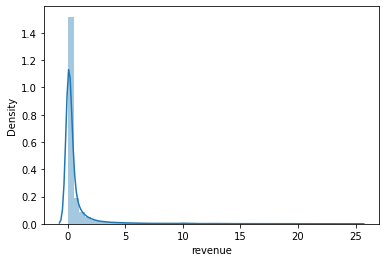

In [76]:
sns.distplot(levelup.query("group_test == '10lvl' & revenue <= 25")['revenue']);
plt.savefig("revenue_dist.pdf")

In [75]:
levelup.query("group_test == '10lvl'")['revenue'].quantile(0.99)

25.02931489518984

In [77]:
bigprice['group_test'].unique()

array(['shown_discount', 'shown_no_discount'], dtype=object)

In [78]:
bigprice.query("group_test == 'shown_discount'")['revenue'].quantile(0.99)


24.168908709091113

/Users/iakubovskii/AppBooster/AB_testing/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


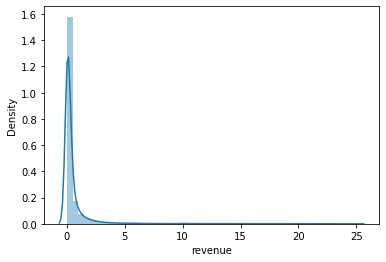

In [79]:
sns.distplot(bigprice.query("group_test == 'shown_discount' & revenue <= 25")['revenue']);
plt.savefig("revenue_dist.pdf")


In [80]:

final_df = pd.read_pickle("/Users/iakubovskii/AppBooster/AB_testing/Data/Quantum_AB_historic/ARPU/Android/final_df")

/Users/iakubovskii/AppBooster/AB_testing/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


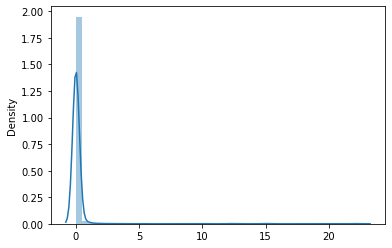

In [86]:
sns.distplot(final_df.query("test_name == 'TrueNoAds' & group_test == 'A' & total_id_revenue < 25")['total_id_revenue'].values)
plt.savefig("delete_plot.pdf")

In [83]:
final_df.columns

Index(['time_to_group', 'total_id_revenue'], dtype='object')